Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive"


MyDrive


In [ ]:
!unzip "/content/gdrive/MyDrive/cnn-assignment/CNN_assignment.zip" -d "/content/gdrive/MyDrive/cnn-assignment/"


Archive:  /content/gdrive/MyDrive/cnn-assignment/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jp

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),seed=123,validation_split=0.2,subset='both')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

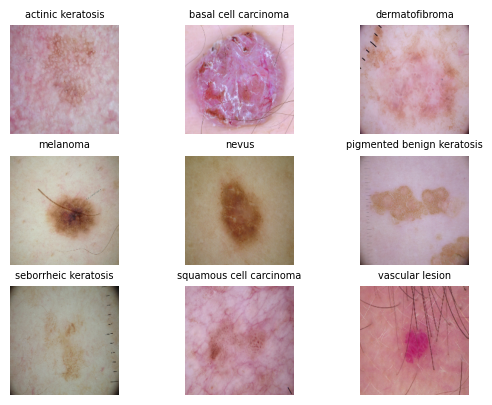

In [8]:
## Unbatching the dataset, and then subsetting it for each class and visualizing one example

val_ds_unbatched = val_ds.unbatch()

for i in range(len(class_names)):
    filtered_ds = val_ds_unbatched.filter(lambda x, l: tf.math.equal(l, i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(class_names[label.numpy()],fontsize=7)
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

- Not using softmax in the output layer, as computing the cross-entropy loss on the probabilities can be numerically unstable, especially when the logits have large or small values
- SparseCategoricalCrossentropy loss function internally applies the softmax operation as part of the loss calculation in a way that improves numerical stability
- This is done by setting : from_logits=True

In [10]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(9)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        1

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 271s 1s/step - loss: 2.1548 - accuracy: 0.3449 - val_loss: 13.1669 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7031 - accuracy: 0.4392 - val_loss: 22.5429 - val_accuracy: 0.1790
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 1.4910 - accuracy: 0.5100 - val_loss: 10.2103 - val_accuracy: 0.0537
Epoch 4/20
56/56 [==============================] - 5s 84ms/step - loss: 1.3855 - accuracy: 0.5396 - val_loss: 8.0495 - val_accuracy: 0.0649
Epoch 5/20
56/56 [==============================] - 5s 83ms/step - loss: 1.3073 - accuracy: 0.5608 - val_loss: 6.4871 - val_accuracy: 0.0716
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 1.1609 - accuracy: 0.6021 - val_loss: 4.9315 - val_accuracy: 0.1834
Epoch 7/20
56/56 [==============================] - 5s 85ms/step - loss: 1.1692 - accuracy: 0.5932 - val_loss: 6.4642 - val_accuracy: 0.1902
Epoch 8/20

### Visualizing training results

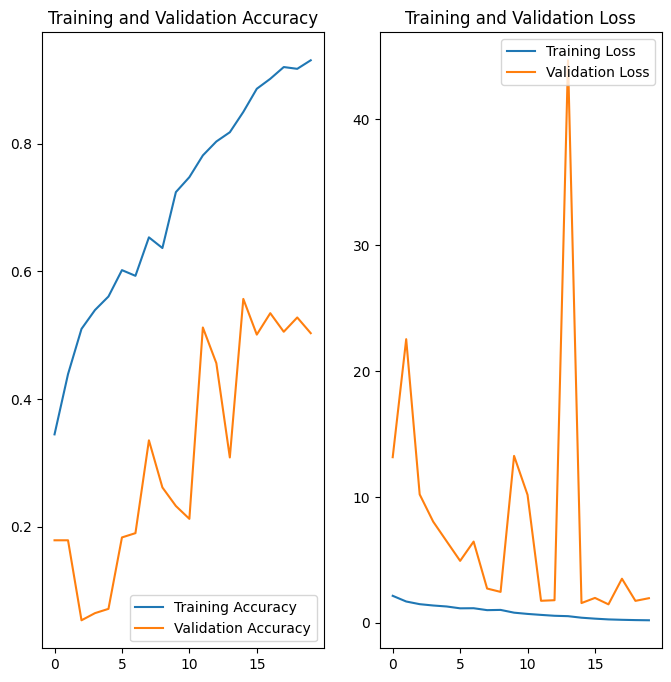

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings

- There is a large difference between training and validation loss as well as accuracy
- The validation accuracy plateaus at around 50%, but the training accuracy keeps going up with each epoch

This points to the possibility that our model is overfitting the training data

In [15]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

## Using random flips, rotations and zoom to create augmented images

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)


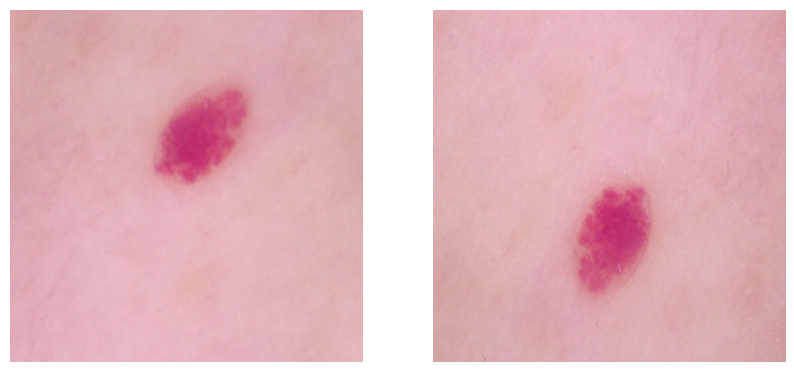

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

## Taking a sample from train_ds and visualizing both the original and augmented versions

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(1, 2, 2)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [16]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

## Added the data augmentation layer to the same model architecture used earlier

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(9)
])



### Compiling the model

In [17]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)       

### Training the model

In [18]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 92ms/step - loss: 2.2497 - accuracy: 0.3438 - val_loss: 13.4583 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.8047 - accuracy: 0.4247 - val_loss: 26.1712 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 1.7117 - accuracy: 0.4442 - val_loss: 6.7709 - val_accuracy: 0.1611
Epoch 4/20
56/56 [==============================] - 5s 88ms/step - loss: 1.6015 - accuracy: 0.4660 - val_loss: 6.2746 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5136 - accuracy: 0.4844 - val_loss: 9.0232 - val_accuracy: 0.1655
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.4345 - accuracy: 0.4950 - val_loss: 7.1716 - val_accuracy: 0.1991
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.4613 - accuracy: 0.4866 - val_loss: 10.3430 - val_accuracy: 0.2506
Epoch 8/20

### Visualizing the results

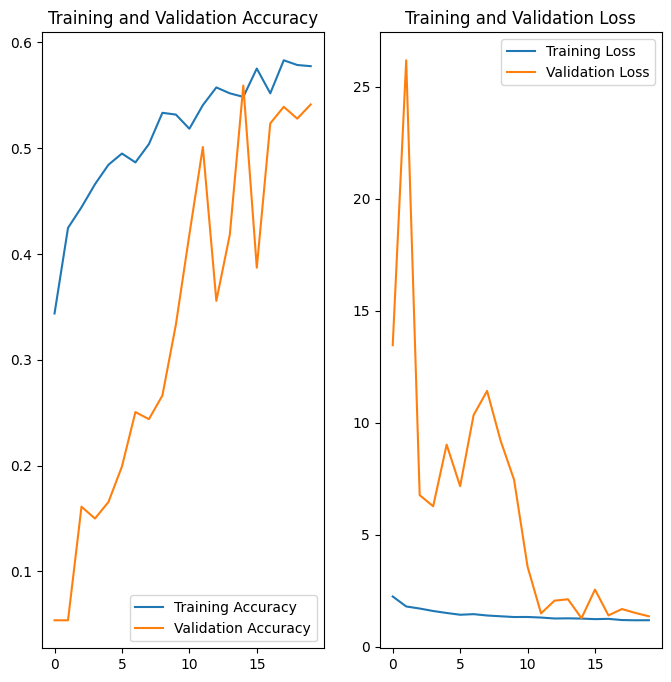

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

- Training and validation accuracy as well as loss are a lot closer to each other now
- The overfitting problem seems to have been solved by the data augmentation

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.

## Getting the counts for each class

class_counts = {}

for _, labels in train_ds:
    labels = labels.numpy()
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

counts = [class_counts[class_label] for class_label in class_labels]

In [35]:
## Printing the counts as % of total samples

percentage_counts = [i/sum(counts) for i in counts]
for i in range(len(counts)):
    print(f"{class_names[i]}: {counts[i]} instances, {percentage_counts[i]:.2%} of the dataset")


actinic keratosis: 370 instances, 20.65% of the dataset
basal cell carcinoma: 352 instances, 19.64% of the dataset
dermatofibroma: 309 instances, 17.24% of the dataset
melanoma: 142 instances, 7.92% of the dataset
nevus: 77 instances, 4.30% of the dataset
pigmented benign keratosis: 115 instances, 6.42% of the dataset
seborrheic keratosis: 58 instances, 3.24% of the dataset
squamous cell carcinoma: 277 instances, 15.46% of the dataset
vascular lesion: 92 instances, 5.13% of the dataset


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

- Seborrheic Keratosis has the least number of samples, followed by Nevus, Vascular Lesion and Melanoma
- Actinic Keratosis, Basal Cell Carcinoma, Dematofibroma and Squamos Cell Carcinoma dominate the data in terms of number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset="/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B02E42D3F70>: 100%|██████████| 500/500 [00:22<00:00, 21.99 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B0248DFBF40>: 100%|██████████| 500/500 [00:18<00:00, 26.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B02E455F8E0>: 100%|██████████| 500/500 [00:17<00:00, 28.75 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B0248E178B0>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7B02E47A1E40>: 100%|██████████| 500/500 [01:20<00:00,  6.24 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B02E4389C90>: 100%|██████████| 500/500 [00:17<00:00, 28.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B026EF5E920>: 100%|██████████| 500/500 [00:40<00:00, 12.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B02813D3EB0>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B02E4389C90>: 100%|██████████| 500/500 [00:17<00:00, 28.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

Added a few lines of code to concatenate the paths and labels for the original dataset and the augmented dataset

In [51]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_old

['/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026857.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030036.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027668.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026212.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027334.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029041.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratos

In [62]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*', '*.jpg'))]
lesion_list_old

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [44]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_e0b94daa-a1de-4b0f-ab47-ec5fe7eb7b16.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_149558e9-12b9-43d7-92ee-7b70c4bd5fc5.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_4bf77486-c3f3-45f4-b16c-6d7d38a18b4e.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_cbc78b65-ba48-45e5-933a-a53f23649609.jpg',
 '/content/gdrive/MyDrive/cnn-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [64]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

original_df_dict = dict(zip(path_list_old, lesion_list_old))



In [66]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(original_df_dict.items()),columns = ['Path','Label'])

new_df = pd.concat([original_df,df2])

In [67]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [68]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [70]:
## We now have much larger training and validation datasets

data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [71]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [75]:
## your code goes here

## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(9)
])





#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [76]:

## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:**  Train your model

In [77]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 39s 212ms/step - loss: 2.0070 - accuracy: 0.3461 - val_loss: 2.8826 - val_accuracy: 0.1492
Epoch 2/50
169/169 [==============================] - 35s 202ms/step - loss: 1.5663 - accuracy: 0.4499 - val_loss: 2.6531 - val_accuracy: 0.1544
Epoch 3/50
169/169 [==============================] - 35s 201ms/step - loss: 1.3265 - accuracy: 0.5341 - val_loss: 1.4241 - val_accuracy: 0.4818
Epoch 4/50
169/169 [==============================] - 37s 213ms/step - loss: 1.1784 - accuracy: 0.5621 - val_loss: 1.2855 - val_accuracy: 0.5434
Epoch 5/50
169/169 [==============================] - 40s 229ms/step - loss: 0.9965 - accuracy: 0.6376 - val_loss: 1.3107 - val_accuracy: 0.5590
Epoch 6/50
169/169 [==============================] - 35s 202ms/step - loss: 0.8980 - accuracy: 0.6716 - val_loss: 1.7961 - val_accuracy: 0.4039
Epoch 7/50
169/169 [==============================] - 35s 202ms/step - loss: 0.7659 - accuracy: 0.7233 - val_loss: 1.1859 - val_ac

#### **Todo:**  Visualize the model results

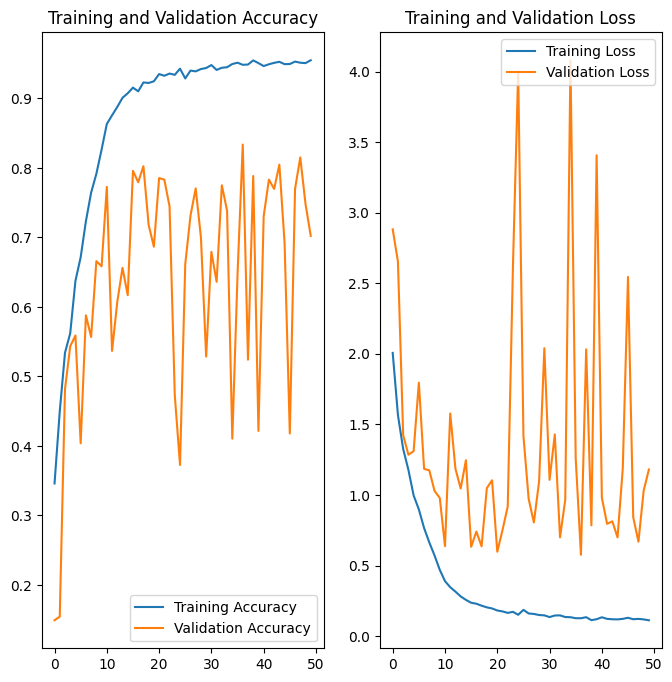

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Class rebalance reduced the overfitting problem - we have higher accuracy on the validation set
- It also improved the accuracy of the model even on the training dataset
- beyond ~20 epochs, the performance on validation dataset does not improve much, and even training performance starts saturating
- Would be best to select a model from the 16th or 18th epoch, and avoid overfitting to the training dataset
